In [40]:
%reset -f

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN, CuDNNLSTM,CuDNNGRU
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model

from matplotlib import pyplot as plt 
%matplotlib inline 

In [42]:
train = pd.read_csv("train-1546603042473.csv",na_values= [""], encoding= "utf-8")
test = pd.read_csv("test-1546603743049.csv",na_values= [""], encoding= "utf-8")

In [43]:
tf.__version__

'1.10.1'

In [44]:
k.__version__

'2.2.2'

In [45]:
train.head()

,categories,converse
0,QUERIES FROM PHARMACY,please to verify instructions for drugname pat...
1,NEW APPOINTMENT,lmovm for patients mother to and schd rov trac...
2,OTHERS,labtype and insurance approval other incoming ...
3,OTHERS,clinical list changes medfusion secure electro...
4,MEDICATION RELATED,wants to wean off medication work phone name d...


In [46]:
test.head()

,id,converse
0,1,request to speak with rn no given patients ref...
1,2,patients husband ret name spouse for other pat...
2,3,fyi in his szs mom other he has an appointment...
3,4,Rx refill drugname from pharmacy name reason f...
4,5,need more time for testing dad is requesting a...


In [47]:
print(train.shape)
print(test.shape)

(48699, 2)
(8581, 2)


In [48]:
print(train.dtypes)
print(test.dtypes)

categories    object
converse      object
dtype: object
id           int64
converse    object
dtype: object


### Preprocessing

In [49]:
train["categories"] = train["categories"].astype(str)
train["converse"] = train["converse"].astype(str)
test["converse"] = test["converse"].astype(str)

In [50]:
print(train.shape)
print(test.shape)

(48699, 2)
(8581, 2)


In [51]:
print("Max length: %s" %train.converse.str.len().max())
print("Mean length: %s" %train.converse.str.len().mean())
print("Min length: %s" %train.converse.str.len().min())

Max length: 2440
Mean length: 473.03648945563566
Min length: 3


In [52]:
MAX_SEQ_LEN = 450
VOCAB_SIZE = 20000

In [53]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(train["converse"])

train_sequences = tokenizer.texts_to_sequences(train["converse"])
test_sequences = tokenizer.texts_to_sequences(test["converse"])

In [54]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35747 unique tokens.


In [55]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(test_data.shape)

(48699, 450)
(8581, 450)


In [56]:
print(len(np.unique(train_data)))

20000


In [57]:
train_labels = train['categories']

In [58]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['CANCELLATION' 'CHANGE OF HOSPITAL' 'CHANGE OF PHARMACY'
 'CHANGE OF PROVIDER' 'FOLLOW UP ON PREVIOUS REQUEST' 'JUNK' 'LAB RESULTS'
 'MEDICATION RELATED' 'NEW APPOINTMENT' 'OTHERS' 'PRIOR AUTHORIZATION'
 'PROVIDER' 'QUERIES FROM INSURANCE FIRM' 'QUERIES FROM PHARMACY'
 'QUERY ON CURRENT APPOINTMENT' 'REFILL' 'RESCHEDULING'
 'RUNNING LATE TO APPOINTMENT'
 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)'
 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)' 'SYMPTOMS']


In [59]:
print(np.unique(train_labels, return_counts = True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), array([ 564,  127,   47,  811,  304,   18, 2253, 9010, 8907, 6253, 1043,
       1677,   91, 1464,  559, 8347, 1383,  590, 3018, 1212, 1021]))


In [60]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

('Train tensor shape:', (48699, 450))
('Train labels tensor shape:', (48699, 21))


### Building Convolutional Neural Network 

In [61]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 3,activation= 'relu',
                 kernel_initializer= INITIALIZER ,
                 #kernel_regularizer= REGULARIZER
                ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',
                 kernel_initializer= INITIALIZER,
                 #kernel_regularizer= REGULARIZER
                 ))
cnn_model.add(GlobalMaxPool1D())
#cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())

#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))
#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))

cnn_model.add(Dense(128, activation= 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(21,activation= 'softmax'))

#### Configure the model for training

In [62]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cnn_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cnn_model.summary()
metric = "val_acc"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 450, 100)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 448, 64)           19264     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 444, 64)           20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
__________

#### Define callbacks

In [63]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                    #restore_best_weights= True)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cnn_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

#### Fit the model

In [64]:
history = cnn_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Train on 38959 samples, validate on 9740 samples
Epoch 1/1000
38959/38959 [==============================] - 11s 293us/step - loss: 2.5941 - acc: 0.5524 - val_loss: 1.3293 - val_acc: 0.6992
Epoch 2/1000
38959/38959 [==============================] - 9s 220us/step - loss: 1.3677 - acc: 0.6801 - val_loss: 1.1958 - val_acc: 0.7144
Epoch 3/1000
38959/38959 [==============================] - 8s 217us/step - loss: 1.2640 - acc: 0.6987 - val_loss: 1.1256 - val_acc: 0.7180
Epoch 4/1000
38959/38959 [==============================] - 8s 217us/step - loss: 1.2157 - acc: 0.7041 - val_loss: 1.1215 - val_acc: 0.7249
Epoch 5/1000
38959/38959 [==============================] - 8s 215us/step - loss: 1.1900 - acc: 0.7103 - val_loss: 1.1184 - val_acc: 0.7155
Epoch 6/1000
38959/38959 [==============================] - 8s 216us/step - loss: 1.1726 - acc: 0.7152 - val_loss: 1.1199 - val_acc: 0.7215
Epoch 7/1000
38959/38959 [==============================] - 8s 218us/step - loss: 1.1551 - acc: 0.7189 - val_l

#### Capture the model metrics

In [65]:
train_acc = history.history['acc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

#### Plot the Model accuracies and losses

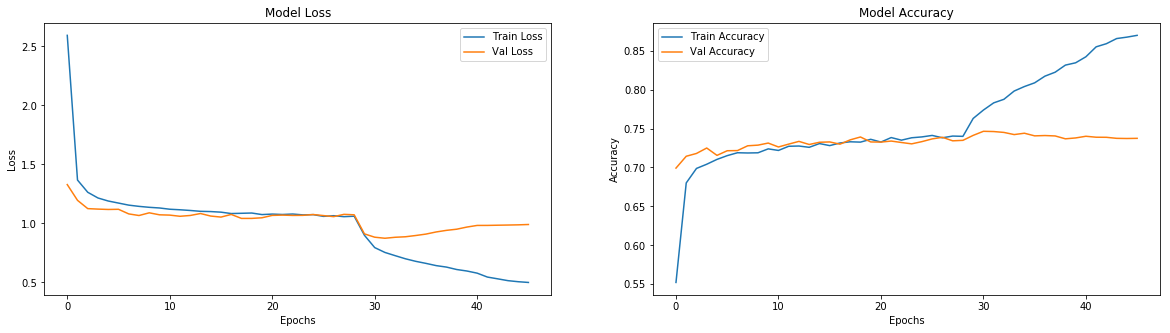

In [66]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [67]:
best_weights_cnn = load_model(file_path)
evaluation = best_weights_cnn.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

48699/48699 [==============================] - 3s 65us/step
('Train Loss: 0.696461', 'Train Accuracy: 0.798066')


### &nbsp;
### Building CuDNNLSTM model

In [68]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cuDNN_LSTM_model = Sequential()
cuDNN_LSTM_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
#cuDNN_LSTM_model.add(Lambda(lambda x: tf.expand_dims(cuDNN_LSTM_model.output, axis=-1)))
cuDNN_LSTM_model.add(CuDNNLSTM(128 ,#activation= 'relu',
               return_sequences=True,
               name="lstm_1"
              ))
cuDNN_LSTM_model.add(CuDNNLSTM(64 ,#activation= 'relu',
               return_sequences=False,
               name="lstm_2"
              ))
cuDNN_LSTM_model.add(Dropout(0.2))
cuDNN_LSTM_model.add(BatchNormalization())

cuDNN_LSTM_model.add(Dense(128,activation= 'relu'))
cuDNN_LSTM_model.add(Dropout(0.5))
cuDNN_LSTM_model.add(BatchNormalization())
cuDNN_LSTM_model.add(Dense(21,activation= 'softmax'))

In [69]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cuDNN_LSTM_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cuDNN_LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 450, 100)          2000000   
_________________________________________________________________
lstm_1 (CuDNNLSTM)           (None, 450, 128)          117760    
_________________________________________________________________
lstm_2 (CuDNNLSTM)           (None, 64)                49664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [70]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                     #restore_best_weights= True)

#file_path = "cnn4_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cudnn_lstm_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [71]:
history = cuDNN_LSTM_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Train on 38959 samples, validate on 9740 samples
Epoch 1/1000
38959/38959 [==============================] - 34s 872us/step - loss: 2.5144 - acc: 0.4939 - val_loss: 1.8192 - val_acc: 0.5520
Epoch 2/1000
38959/38959 [==============================] - 32s 818us/step - loss: 1.6478 - acc: 0.5745 - val_loss: 1.7453 - val_acc: 0.5604
Epoch 3/1000
38959/38959 [==============================] - 32s 831us/step - loss: 1.6529 - acc: 0.5766 - val_loss: 1.4954 - val_acc: 0.6174
Epoch 4/1000
38959/38959 [==============================] - 32s 811us/step - loss: 1.6545 - acc: 0.5776 - val_loss: 2.8305 - val_acc: 0.3899
Epoch 5/1000
38959/38959 [==============================] - 31s 802us/step - loss: 1.6570 - acc: 0.5747 - val_loss: 1.5512 - val_acc: 0.6154
Epoch 6/1000
38959/38959 [==============================] - 32s 817us/step - loss: 1.5123 - acc: 0.6240 - val_loss: 1.6417 - val_acc: 0.6011
Epoch 7/1000
38959/38959 [==============================] - 32s 822us/step - loss: 1.4589 - acc: 0.6309 -

In [72]:
train_acc = history.history['acc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

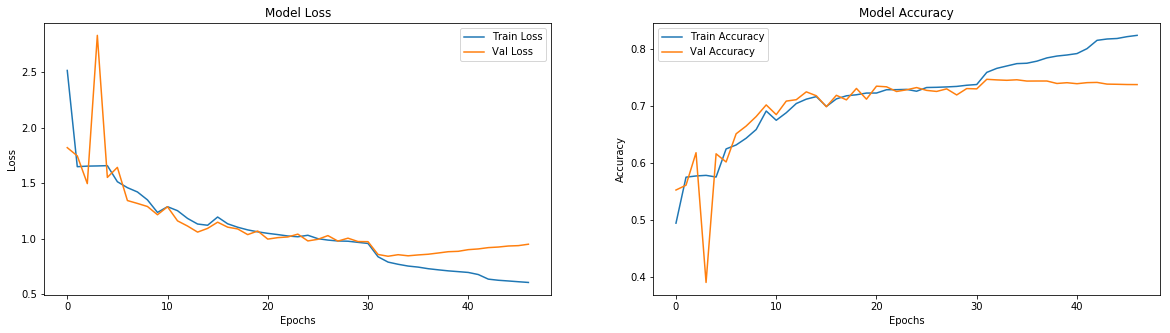

In [73]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [74]:
best_weights_lstm = load_model(file_path)
evaluation = best_weights_lstm.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

48699/48699 [==============================] - 29s 586us/step
('Train Loss: 0.746703', 'Train Accuracy: 0.772788')


### &nbsp;
### Building CuDNNGRU model

In [75]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cuDNN_GRU_model = Sequential()
cuDNN_GRU_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))


#cuDNN_GRU_model.add(Lambda(lambda x: tf.expand_dims(cuDNN_GRU_model.output, axis=-1)))
cuDNN_GRU_model.add(CuDNNGRU(128, return_sequences= True)) 
cuDNN_GRU_model.add(CuDNNGRU(64, return_sequences= True))
cuDNN_GRU_model.add(CuDNNGRU(32, return_sequences= False))
cuDNN_GRU_model.add(Dropout(0.2))
cuDNN_GRU_model.add(BatchNormalization())

cuDNN_GRU_model.add(Dense(128,activation= 'relu'))
cuDNN_GRU_model.add(Dropout(0.5))
cuDNN_GRU_model.add(BatchNormalization())
cuDNN_GRU_model.add(Dense(21,activation= 'softmax'))

In [76]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cuDNN_GRU_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cuDNN_GRU_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 450, 100)          2000000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 450, 128)          88320     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 450, 64)           37248     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 32)                9408      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
__________

In [77]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                     #restore_best_weights= True)

#file_path = "cnn4_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cudnn_gru_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [78]:
history = cuDNN_GRU_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Train on 38959 samples, validate on 9740 samples
Epoch 1/1000
38959/38959 [==============================] - 48s 1ms/step - loss: 2.6595 - acc: 0.4353 - val_loss: 3.2530 - val_acc: 0.4230
Epoch 2/1000
38959/38959 [==============================] - 45s 1ms/step - loss: 1.4954 - acc: 0.5999 - val_loss: 1.3414 - val_acc: 0.6589
Epoch 3/1000
38959/38959 [==============================] - 44s 1ms/step - loss: 1.2861 - acc: 0.6645 - val_loss: 1.2146 - val_acc: 0.6810
Epoch 4/1000
38959/38959 [==============================] - 44s 1ms/step - loss: 1.2232 - acc: 0.6833 - val_loss: 1.1312 - val_acc: 0.7071
Epoch 5/1000
38959/38959 [==============================] - 43s 1ms/step - loss: 1.1800 - acc: 0.6985 - val_loss: 1.1559 - val_acc: 0.7053
Epoch 6/1000
38959/38959 [==============================] - 42s 1ms/step - loss: 1.1474 - acc: 0.7052 - val_loss: 1.0740 - val_acc: 0.7189
Epoch 7/1000
38959/38959 [==============================] - 46s 1ms/step - loss: 1.1282 - acc: 0.7096 - val_loss: 1.1

In [79]:
train_acc = history.history['acc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

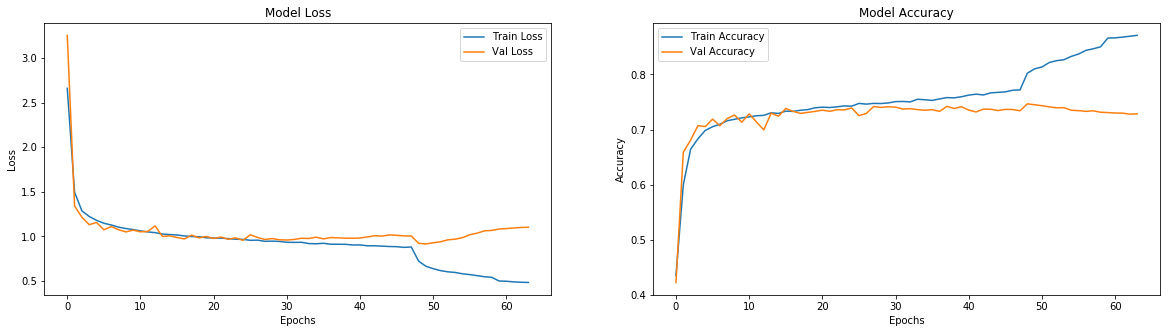

In [80]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [81]:
best_weights_gru = load_model(file_path)
evaluation = best_weights_gru.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

48699/48699 [==============================] - 42s 858us/step
('Train Loss: 0.551755', 'Train Accuracy: 0.857492')


In [82]:
#plot_model(model, to_file='model.png')

### Write results to csv for submission

In [83]:
test_preds = best_weights_gru.predict_classes(test_data)
result1_df = pd.DataFrame({"id" : test["id"]})
result1_df["categories"] = label_encoder.classes_[test_preds]
#print(result1_df.shape)
#result1_df.head()
result1_df.to_csv("result3.csv", index=False)